<a href="https://colab.research.google.com/github/adammahabayu/DataScience/blob/main/Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data berhasil dimuat. 5 baris pertama:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  

Membersihkan data: 6 baris dengan data hilang dihapus.

Data setelah standarisasi (5 baris pertama):
        mpg  cylinders  displacement  horsepower    weight  acceleration  \
0 -0.698638   1.483947      1.077290    0.664133  0.6205

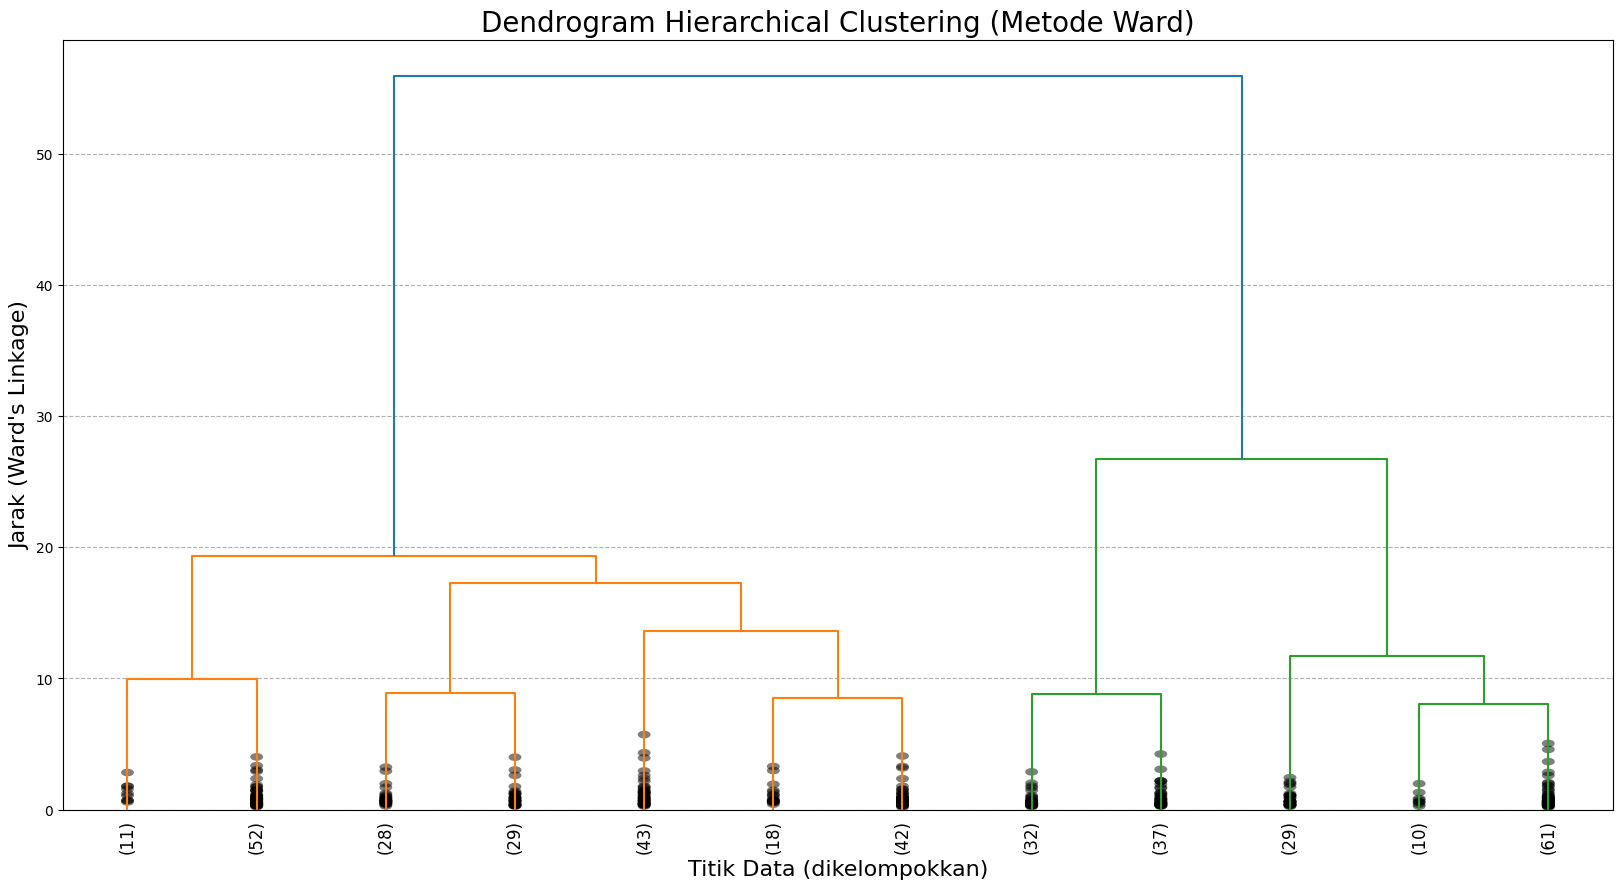

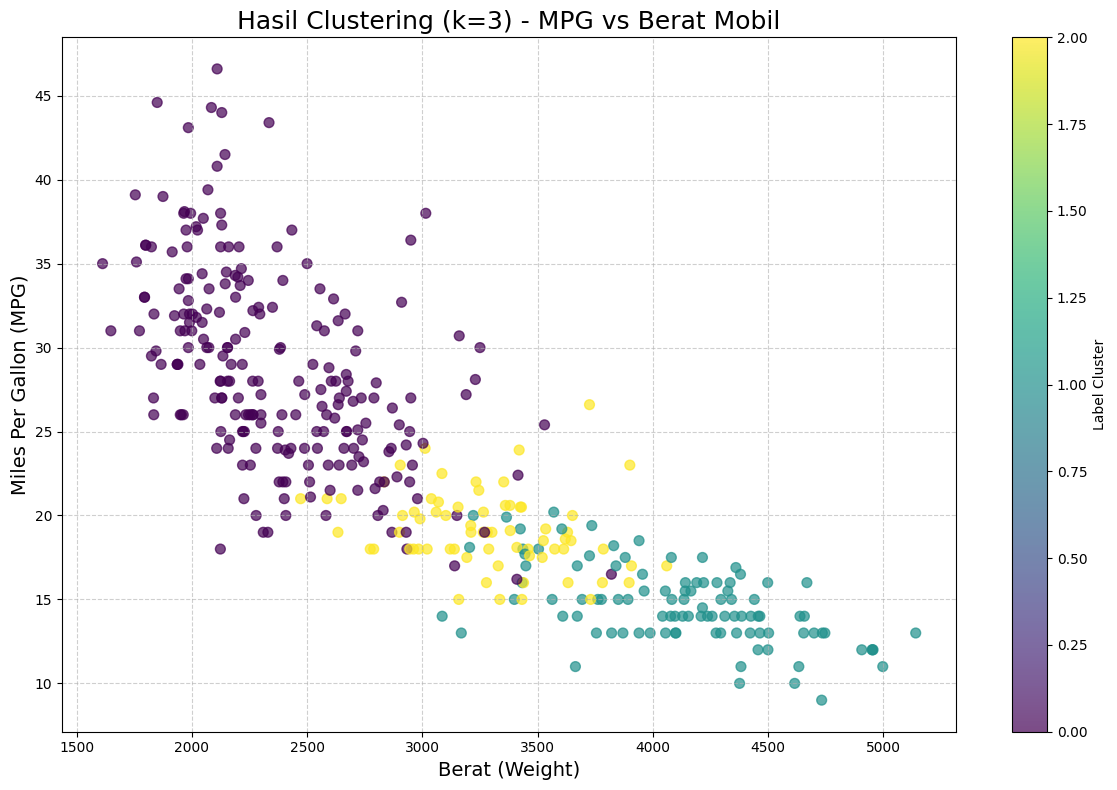

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

# Mengabaikan peringatan yang mungkin muncul (opsional)
warnings.filterwarnings('ignore', category=FutureWarning)

def jalankan_clustering(filepath='auto-mpg.data'):
    """
    Fungsi lengkap untuk memuat, membersihkan, dan melakukan
    hierarchical clustering pada dataset auto-mpg.
    """

    # --- 1. Memuat Data ---
    # Mendefinisikan nama kolom secara manual karena file data tidak memiliki header
    column_names = [
        'mpg', 'cylinders', 'displacement', 'horsepower',
        'weight', 'acceleration', 'model_year', 'origin', 'car_name'
    ]

    # Membaca data: pemisah adalah satu atau lebih spasi (\s+)
    try:
        df = pd.read_csv(
            filepath,
            header=None,
            names=column_names,
            delim_whitespace=True,
            na_values='?' # Mengganti nilai '?' dengan NaN (Not a Number)
        )
    except FileNotFoundError:
        print(f"Error: File '{filepath}' tidak ditemukan.")
        print("Pastikan file 'auto-mpg.data' berada di direktori yang sama dengan script ini.")
        return
    except Exception as e:
        print(f"Error saat membaca file: {e}")
        return

    print("Data berhasil dimuat. 5 baris pertama:")
    print(df.head())

    # --- 2. Pembersihan Data (Data Cleaning) ---

    # Menghapus kolom 'car_name' karena tidak relevan untuk clustering
    # axis=1 berarti kita menghapus kolom, bukan baris
    df_clean = df.drop('car_name', axis=1)

    # Menghapus baris yang memiliki nilai NaN (yang berasal dari '?')
    # Ini adalah cara paling sederhana; cara lain adalah imputasi (mengisi nilai)
    initial_rows = df_clean.shape[0]
    df_clean = df_clean.dropna()
    final_rows = df_clean.shape[0]

    print(f"\nMembersihkan data: {initial_rows - final_rows} baris dengan data hilang dihapus.")

    # Menyimpan salinan data yang sudah dibersihkan untuk pelabelan plot
    df_plotting = df_clean.copy()

    # --- 3. Pra-pemrosesan Data (Data Preprocessing) ---

    # Hierarchical clustering sangat sensitif terhadap skala fitur.
    # Fitur seperti 'weight' (ribuan) akan mendominasi 'cylinders' (satuan).
    # Kita perlu melakukan standarisasi (membuat mean=0, std_dev=1)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_clean)

    # Mengubah kembali ke DataFrame untuk memudahkan (opsional)
    df_scaled = pd.DataFrame(features_scaled, columns=df_clean.columns)

    print("\nData setelah standarisasi (5 baris pertama):")
    print(df_scaled.head())

    # --- 4. Membuat Dendrogram (Visualisasi "Hipotesa") ---

    # Di sinilah kita menggunakan "Linkage Criterion" (Kriteria Keterkaitan)
    # Kita gunakan 'ward' linkage, yang meminimalkan varians (mirip 'cost function')
    # Kita hitung matriks linkage

    print("\nMembuat matriks linkage untuk dendrogram...")
    # 'ward' linkage adalah pilihan umum yang bekerja dengan baik
    linkage_matrix = linkage(df_scaled, method='ward', metric='euclidean')

    # Membuat plot Dendrogram
    plt.figure(figsize=(20, 10))
    plt.title('Dendrogram Hierarchical Clustering (Metode Ward)', fontsize=20)
    plt.xlabel('Titik Data (dikelompokkan)', fontsize=16)
    plt.ylabel('Jarak (Ward\'s Linkage)', fontsize=16)

    # 'truncate_mode='lastp'' dan 'p=12' berarti kita hanya menampilkan
    # 12 penggabungan cluster terakhir agar plot lebih rapi.
    dendrogram(
        linkage_matrix,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
    )
    plt.grid(axis='y', linestyle='--')
    print("Plot Dendrogram dibuat (Figure 1).")

    # --- 5. Menerapkan Model Clustering (Agglomerative Clustering) ---

    # Berdasarkan dendrogram, kita bisa memilih jumlah cluster.
    # Mari kita coba potong untuk mendapatkan 3 cluster (mungkin mewakili 'origin'?)
    n_clusters_pilihan = 3

    print(f"\nMenerapkan model Agglomerative Clustering dengan {n_clusters_pilihan} clusters...")

    # 'affinity' adalah metrik jarak (poin 1 dari penjelasan)
    # 'linkage' adalah kriteria keterkaitan (poin 2 dari penjelasan)
    model = AgglomerativeClustering(
        n_clusters=n_clusters_pilihan,
        metric='euclidean',
        linkage='ward'
    )

    # Melatih model dan mendapatkan label cluster untuk setiap titik data
    cluster_labels = model.fit_predict(df_scaled)

    # Menambahkan label cluster kembali ke DataFrame asli (yang belum diskalakan)
    df_plotting['cluster'] = cluster_labels

    print("Label cluster ditambahkan ke data.")
    print(df_plotting.head())

    # --- 6. Visualisasi Hasil Clustering ---

    # Kita tidak bisa memvisualisasikan 8 dimensi.
    # Mari kita buat scatter plot dari dua fitur paling penting: 'weight' dan 'mpg'

    plt.figure(figsize=(12, 8))
    # 'c=cluster_labels' mewarnai titik berdasarkan cluster yang ditetapkan
    # 'cmap='viridis'' adalah skema warna
    plt.scatter(
        df_plotting['weight'],
        df_plotting['mpg'],
        c=df_plotting['cluster'],
        cmap='viridis',
        alpha=0.7,
        s=50 # ukuran titik
    )

    plt.title(f'Hasil Clustering (k={n_clusters_pilihan}) - MPG vs Berat Mobil', fontsize=18)
    plt.xlabel('Berat (Weight)', fontsize=14)
    plt.ylabel('Miles Per Gallon (MPG)', fontsize=14)
    plt.colorbar(label='Label Cluster')
    plt.grid(linestyle='--', alpha=0.6)
    print("Plot Scatter Hasil Clustering dibuat (Figure 2).")

    # Menampilkan semua plot
    plt.tight_layout()
    plt.show()

# --- Menjalankan skrip ---
if __name__ == "__main__":
    jalankan_clustering()